In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import regularizers
from keras import layers
from ipywidgets import widgets
from io import BytesIO

In [ ]:
!git clone https://github.com/GitKentC/dataset.git

fatal: destination path 'dataset' already exists and is not an empty directory.


In [ ]:
DATASET_DIR = '/content/dataset/dupe_cleaned/garbage_classification'
TRAIN_DIR = '/content/dataset/split/garbage_classification/train'
VALIDATION_DIR = '/content/dataset/split/garbage_classification/validation'
TEST_DIR = '/content/dataset/split/garbage_classification/test'

In [ ]:
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 64
LABEL_MODE = 'categorical'
COLOR_MODE = 'rgb'

def load_datasets():
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        TRAIN_DIR,
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        VALIDATION_DIR,
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE
    )

    test_dataset = tf.keras.utils.image_dataset_from_directory(
        TEST_DIR,
        image_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE
    )

    return train_dataset, validation_dataset, test_dataset

In [ ]:
train_dataset, validation_dataset, test_dataset = load_datasets()

Found 10815 files belonging to 12 classes.
Found 3087 files belonging to 12 classes.
Found 1556 files belonging to 12 classes.


In [ ]:
def preprocess(image, label):
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [ ]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

test_dataset_final = (test_dataset
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      )

In [ ]:
def create_pre_trained_model():
    pre_trained_model = tf.keras.applications.ResNet50(
        include_top = False,
        input_shape = (150, 150, 3),
        weights = "imagenet"
    )

    for layer in pre_trained_model.layers:
        layer.trainable = False

    return pre_trained_model

pre_trained_model = create_pre_trained_model()
pre_trained_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
def output_of_last_layer(pre_trained_model):
    last_desired_layer = pre_trained_model.get_layer('conv5_block3_out')
    last_output = last_desired_layer.output

    print('Last layer output shape: ', last_output.shape)

    return last_output

last_output = output_of_last_layer(pre_trained_model)

Last layer output shape:  (None, 5, 5, 2048)


In [ ]:
def create_model(pre_trained_model, last_output):
    x = tf.keras.layers.Flatten()(last_output)
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(12, activation='softmax')(x)

    model = tf.keras.Model(inputs = pre_trained_model.input, outputs = x)

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss = 'categorical_crossentropy',
        metrics = ['accuracy']
    )

    return model

model = create_model(pre_trained_model, last_output)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 49,808,780 (190.01 MB)

 Trainable params: 26,221,068 (100.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        if accuracy >= 0.95 and val_accuracy >= 0.96:
            self.model.stop_training = True
            print(f"\nReached accuracy: {accuracy:.4f} and val_accuracy: {val_accuracy:.4f}, so cancelling training!")

In [ ]:
history = model.fit(train_dataset_final,
                    validation_data = validation_dataset_final,
                    epochs = 10,
                    verbose = 2,
                    callbacks = [EarlyStoppingCallback()]
                    )

Epoch 1/10
169/169 - 51s - 304ms/step - accuracy: 0.7618 - loss: 1.9321 - val_accuracy: 0.9116 - val_loss: 1.3019
Epoch 2/10
169/169 - 18s - 107ms/step - accuracy: 0.9294 - loss: 1.2189 - val_accuracy: 0.9294 - val_loss: 1.2399
Epoch 3/10
169/169 - 18s - 108ms/step - accuracy: 0.9707 - loss: 1.1037 - val_accuracy: 0.9355 - val_loss: 1.2166
Epoch 4/10
169/169 - 21s - 124ms/step - accuracy: 0.9841 - loss: 1.0558 - val_accuracy: 0.9385 - val_loss: 1.2019
Epoch 5/10
169/169 - 19s - 115ms/step - accuracy: 0.9917 - loss: 1.0316 - val_accuracy: 0.9404 - val_loss: 1.1939
Epoch 6/10
169/169 - 19s - 113ms/step - accuracy: 0.9958 - loss: 1.0152 - val_accuracy: 0.9420 - val_loss: 1.1848
Epoch 7/10
169/169 - 20s - 119ms/step - accuracy: 0.9969 - loss: 1.0058 - val_accuracy: 0.9430 - val_loss: 1.1794
Epoch 8/10
169/169 - 20s - 121ms/step - accuracy: 0.9980 - loss: 0.9955 - val_accuracy: 0.9433 - val_loss: 1.1692
Epoch 9/10
169/169 - 21s - 123ms/step - accuracy: 0.9980 - loss: 0.9883 - val_accuracy: 

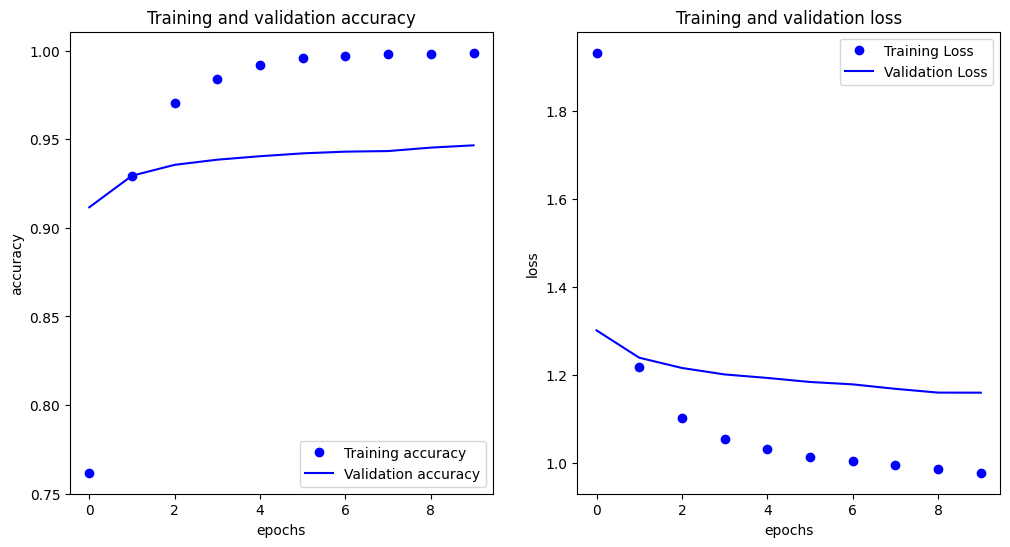

In [ ]:
def plot_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()

    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()

    plt.show()

plot_loss_acc(history)

In [ ]:
loss, accuracy = model.evaluate(test_dataset_final, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.9357 - loss: 1.2017
Test Loss: 1.1819947957992554
Test Accuracy: 0.9408740401268005
